# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
import glob
import matplotlib.pyplot as plt
import math
import cv2


%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import LeaveOneOut

# Importing Data

In [3]:
data_nail = pd.read_excel("merged_data.xlsx", sheet_name="nail")
data_tongue = pd.read_excel("merged_data.xlsx", sheet_name="tongue")
data_palm = pd.read_excel("merged_data.xlsx", sheet_name="palm")
common_ids = pd.read_excel("merged_data.xlsx", sheet_name="common_ids")

In [4]:
train, test = train_test_split(common_ids, test_size=0.1)
train, test = train["number"].tolist(), test["number"].tolist()

In [5]:
nail_train, nail_test = data_nail[data_nail['number'].isin(train)], data_nail[data_nail['number'].isin(test)]
tongue_train, tongue_test = data_tongue[data_tongue['number'].isin(train)], data_tongue[data_tongue['number'].isin(test)]
palm_train, palm_test = data_palm[data_palm['number'].isin(train)], data_palm[data_palm['number'].isin(test)]

## Nail

In [6]:
X_nail_train = nail_train.drop(columns=['number','label']).to_numpy()
X_nail_test = nail_test.drop(columns=['number','label']).to_numpy()

## Tongue

In [7]:
X_tongue_train = tongue_train.drop(columns=['number','label']).to_numpy()
X_tongue_test = tongue_test.drop(columns=['number','label']).to_numpy()

## Palm

In [8]:
X_palm_train = palm_train.drop(columns=['number','label']).to_numpy()
X_palm_test = palm_test.drop(columns=['number','label']).to_numpy()

## Labels

In [9]:
y_train = nail_train['label'].to_numpy()
y_test = nail_test['label'].to_numpy()

# Preprocessing

In [10]:
scaler = MinMaxScaler(copy=False)
# scaler = StandardScaler(copy=False)

In [11]:
X_nail_train = scaler.fit_transform(X_nail_train)
X_nail_test = scaler.fit_transform(X_nail_test)

In [12]:
X_tongue_train = scaler.fit_transform(X_tongue_train)
X_tongue_test = scaler.fit_transform(X_tongue_test)

In [13]:
X_palm_train = scaler.fit_transform(X_palm_train)
X_palm_test = scaler.fit_transform(X_palm_test)

# Helper Functions

In [14]:
def predict(X,beta,b):
    return np.dot(X,beta) + b

In [15]:
def loss(y_true,y_hat,y_pred,coeff,mse):
    
    y_nail, y_tongue, y_palm = y_pred
    a, b, c = coeff
    mse_nail, mse_tongue, mse_palm = mse

    cost = mean_squared_error(y_true, y_hat) + a*mse_nail + b*mse_tongue + c*mse_palm

    return cost

In [16]:
def gradients(y_true,y_hat,weights,coeff,X,intercept):

    weights_nail, weights_tongue, weights_palm = weights
    b_nail, b_tongue, b_palm = intercept
    X_nail, X_tongue, X_palm = X
    a, b, c = coeff
    
    y_pred_nail = predict(X_nail, beta_nail, b_nail)
    y_pred_tongue = predict(X_tongue, beta_tongue, b_tongue)
    y_pred_palm = predict(X_palm, beta_palm, b_palm)

    N = X_nail.shape[0]

    # print(X_nail.shape)
    # print(y_true.shape)
    # print(y_hat.shape)
    # print(y_pred_nail.shape)
    
    dw_nail = (-2*a)*np.dot(X_nail.T,2*y_true-y_hat-y_pred_nail)/N
    dw_tongue = (-2*b)*np.dot(X_tongue.T,2*y_true-y_hat-y_pred_tongue)/N
    dw_palm = (-2*c)*np.dot(X_palm.T,2*y_true-y_hat-y_pred_palm)/N

    db_nail = (-2*a/N)*np.sum(2*y_true-y_hat-y_pred_nail)
    db_tongue = (-2*b/N)*np.sum(2*y_true-y_hat-y_pred_tongue)
    db_palm = (-2*c/N)*np.sum(2*y_true-y_hat-y_pred_palm)

    da = (np.dot(y_true,y_true) - 4*np.dot(y_true,y_pred_nail) + np.dot(y_pred_nail,y_pred_nail) - np.dot(y_hat,y_pred_nail))/N
    db = (np.dot(y_true,y_true) - 4*np.dot(y_true,y_pred_tongue) + np.dot(y_pred_tongue,y_pred_tongue) - np.dot(y_hat,y_pred_tongue))/N
    dc = (np.dot(y_true,y_true) - 4*np.dot(y_true,y_pred_palm) + np.dot(y_pred_palm,y_pred_palm) - np.dot(y_hat,y_pred_palm))/N
    

    return [dw_nail, dw_tongue, dw_palm, db_nail, db_tongue, db_palm, da, db, dc]

In [17]:
def sq_sum(a,b,c):
    return math.sqrt(a**2 + b**2 + c**2)

# Driver Code

## Initilisation 

In [18]:
a, b, c = 0.0, 0.0, 0.0

features = X_nail_train.shape[1]

beta_nail = np.array([1.0]*features)
b_nail = 1.0

beta_tongue = np.array([1.0]*features)
b_tongue = 1.0

beta_palm = np.array([1.0]*features)
b_palm = 1.0

train_loss = []
mse_nail_loss = []
mse_tongue_loss = []
mse_palm_loss = []

y_hat_train_test_list = []
y_train_test_list = []

alpha = 0.1
iterations = 5

print(f"Shape of training data is {X_nail_train.shape}")

Shape of training data is (234, 14)


## Training

In [19]:
# create loocv procedure
cv = LeaveOneOut()

Training Complete
-----------------------------------------------------------------------------------------
Mean Absolute Error is 3.1906
R-square is -2.2332
Mean Squared Error is 12.9178
-----------------------------------------------------------------------------------------


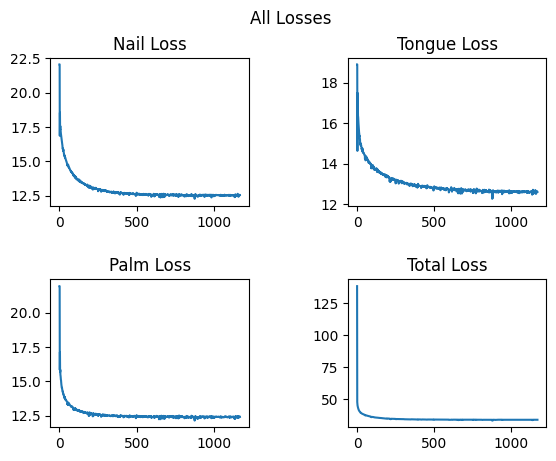

In [20]:
for train_ix, test_ix in cv.split(X_tongue_train):
    
    # split data
    X_nail_train_train, X_nail_train_test = X_nail_train[train_ix, :], X_nail_train[test_ix, :]
    X_tongue_train_train, X_tongue_train_test = X_tongue_train[train_ix, :], X_tongue_train[test_ix, :]
    X_palm_train_train, X_palm_train_test = X_palm_train[train_ix, :], X_palm_train[test_ix, :]    
    
    y_train_train, y_train_test = y_train[train_ix], y_train[test_ix]

    # TRAINING
    for i in range(iterations):
    
        # print(f"-----------------------------------------------------------------------------------------")
        # print(f"Iteration {i+1}")
    
        
        # PREDICTION
        y_pred_nail = predict(X_nail_train_train, beta_nail, b_nail)
        y_pred_tongue = predict(X_tongue_train_train, beta_tongue, b_tongue)
        y_pred_palm = predict(X_palm_train_train, beta_palm, b_palm)
    
        # print(f"actual prediction = {y_train}")    
        # print(f"beta coeff of nail = {beta_nail}")
        # print(f"prediction of tongue = {y_pred_tongue}")
        # print(f"prediction of palm = {y_pred_palm}")
    
        
        # MEAN SQUARED ERROR
        mse_nail = mean_squared_error(y_train_train, y_pred_nail)
        mse_tongue = mean_squared_error(y_train_train, y_pred_tongue)
        mse_palm = mean_squared_error(y_train_train, y_pred_palm)
        
        mse_nail_loss.append(mse_nail)
        mse_tongue_loss.append(mse_tongue)
        mse_palm_loss.append(mse_palm)
    
      
        # print(f"mse of nail = {mse_nail}")
        # print(f"mse of tongue = {mse_tongue}")
        # print(f"mse of palm = {mse_palm}")
    
        
        # # SUM OF SQUARES OF COEFF = 1
        # denom = sq_sum(a,b,c)
        # a, b, c = a/denom, b/denom, c/denom
    
        
        # FINAL PREDICTION
        y_hat = a*y_pred_nail + b*y_pred_tongue + c*y_pred_palm
        # print(f"prediction = {y_hat}")
        # print(f"mse overall = {mean_squared_error(y_train, y_hat)}")
    
        
        # LOSS FUNCTION ATTRIBUTES
        y_pred = [y_pred_nail, y_pred_tongue, y_pred_palm]
        coeff = [a, b, c]
        weights = [beta_nail, beta_tongue, beta_palm]
        mse = [mse_nail, mse_tongue, mse_palm]
        X = [X_nail_train_train, X_tongue_train_train, X_palm_train_train]
        intercept = [b_nail, b_tongue, b_palm]
    
        
        # LOSS FUNCTION
        train_loss.append(loss(y_train_train,y_hat,y_pred,coeff,mse))
        
        
        # GRADIENTS
        dw = gradients(y_train_train,y_hat,weights,coeff,X,intercept)
        dw_nail, dw_tongue, dw_palm, db_nail, db_tongue, db_palm, da, db, dc = dw
    
        
        # UPDATING PARAMETERS
        beta_nail -= alpha*dw_nail
        beta_tongue -= alpha*dw_tongue
        beta_palm -= alpha*dw_palm
        
        b_nail -= alpha*db_nail
        b_tongue -= alpha*db_tongue
        b_palm -= alpha*db_palm
        
        a -= alpha*da 
        b -= alpha*db 
        c -= alpha*dc
    
        # SUM OF SQUARES OF COEFF = 1
        denom = sq_sum(a,b,c)
        a, b, c = a/denom, b/denom, c/denom

    # TESTING
    y_pred_nail = predict(X_nail_train_test, beta_nail, b_nail)
    y_pred_tongue = predict(X_tongue_train_test, beta_tongue, b_tongue)
    y_pred_palm = predict(X_palm_train_test, beta_palm, b_palm)

    y_hat_train_test = a*y_pred_nail + b*y_pred_tongue + c*y_pred_palm
    y_hat_train_test_list.append(y_hat_train_test)

    y_train_test_list.append(y_train_test)

print("Training Complete")


print(f"-----------------------------------------------------------------------------------------")
print(f"Mean Absolute Error is {round(mean_absolute_error(np.array(y_train_test_list), np.array(y_hat_train_test_list)),4)}")
print(f"R-square is {round(r2_score(np.array(y_train_test_list), np.array(y_hat_train_test_list)),4)}")
print(f"Mean Squared Error is {round(mean_squared_error(np.array(y_train_test_list), np.array(y_hat_train_test_list)),4)}")
print(f"-----------------------------------------------------------------------------------------")



# Plotting Nail Loss
plt.subplot(2,2,1)
plt.plot(mse_nail_loss)
plt.title("Nail Loss")

# Plotting Tongue Loss
plt.subplot(2,2,2)
plt.plot(mse_tongue_loss)
plt.title("Tongue Loss")

# Plotting Palm Loss
plt.subplot(2,2,3)
plt.plot(mse_palm_loss)
plt.title("Palm Loss")

# Plotting Total Loss
plt.subplot(2,2,4)
plt.plot(train_loss)
plt.title("Total Loss")

plt.suptitle("All Losses")
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In [21]:
print(f"coeff of nail = {a}")
print(f"coeff of tongue = {b}")
print(f"coeff of palm = {c}")

coeff of nail = 0.5772105766235797
coeff of tongue = 0.576560181891429
coeff of palm = 0.578278744976155


In [22]:
print(f"Mean of last 50 values of training loss is {round(np.mean(np.array(train_loss[-50:])),4)}")
print(f"Standard Deviation in last 50 values of training loss is {round(np.std(np.array(train_loss[-50:])),4)}")

Mean of last 50 values of training loss is 33.9382
Standard Deviation in last 50 values of training loss is 0.0706


In [23]:
print(f"Mean of last 50 values of nail loss is {round(np.mean(np.array(mse_nail_loss[-50:])),4)}")
print(f"Standard Deviation in last 50 values of nail loss is {round(np.std(np.array(mse_nail_loss[-50:])),4)}")

Mean of last 50 values of nail loss is 12.5152
Standard Deviation in last 50 values of nail loss is 0.0436


In [24]:
print(f"Mean of last 50 values of tongue loss is {round(np.mean(np.array(mse_tongue_loss[-50:])),4)}")
print(f"Standard Deviation in last 50 values of tongue loss is {round(np.std(np.array(mse_tongue_loss[-50:])),4)}")

Mean of last 50 values of tongue loss is 12.5924
Standard Deviation in last 50 values of tongue loss is 0.0419


In [25]:
print(f"Mean of last 50 values of palm loss is {round(np.mean(np.array(mse_palm_loss[-50:])),4)}")
print(f"Standard Deviation in last 50 values of palm loss is {round(np.std(np.array(mse_palm_loss[-50:])),4)}")

Mean of last 50 values of palm loss is 12.3918
Standard Deviation in last 50 values of palm loss is 0.0411


In [26]:
print(f"beta coeff of nail = {beta_nail}")    
print(f"-----------------------------------------------------------------------------------------")
print(f"beta coeff of tongue = {beta_tongue}")
print(f"-----------------------------------------------------------------------------------------")
print(f"beta coeff of palm = {beta_palm}")

beta coeff of nail = [-0.89969892 -0.52054846  2.4906228   2.69108973 -0.36680427 -0.24462929
 -0.70905208 -0.25358204 -0.48479323  0.19608682  0.48760065 -0.70905208
 -1.27893366 -1.4346409 ]
-----------------------------------------------------------------------------------------
beta coeff of tongue = [-0.70091751  0.44138705  0.9463737  -0.52802672  1.50936588  0.64555457
 -0.24440927 -0.64686011 -0.03065603 -0.56985482 -0.88174061 -0.24440927
 -1.54831571 -1.43538538]
-----------------------------------------------------------------------------------------
beta coeff of palm = [-0.42059614 -0.40350403  3.75704983  1.61050933  1.18162297  2.45713233
 -0.51422678 -0.4969403   0.08852982 -0.27644386  0.02314258 -0.51422678
 -1.2079308  -1.3461302 ]


In [27]:
print(f"intercept coeff of nail = {b_nail}")
print(f"intercept coeff of tongue = {b_tongue}")
print(f"intercept coeff of palm = {b_palm}")

intercept coeff of nail = 9.17724533142566
intercept coeff of tongue = 9.95622755692674
intercept coeff of palm = 6.799411953785961


# Testing

In [28]:
print(f"Shape of training data is {X_nail_test.shape}")

Shape of training data is (26, 14)


In [29]:
y_pred_nail = predict(X_nail_test, beta_nail, b_nail)
y_pred_tongue = predict(X_tongue_test, beta_tongue, b_tongue)
y_pred_palm = predict(X_palm_test, beta_palm, b_palm)

In [30]:
y_test
y_hat_test = a*y_pred_nail + b*y_pred_tongue + c*y_pred_palm

In [31]:
print(f"Mean Absolute Error is {round(mean_absolute_error(y_test, y_hat_test),4)}")

Mean Absolute Error is 2.9035


In [32]:
print(f"R-Square is {round(r2_score(y_test, y_hat_test),4)}")

R-Square is -2.7134


In [33]:
print(f"Mean Squared Error is {round(mean_squared_error(y_test, y_hat_test),4)}")

Mean Squared Error is 10.6664
